# Stocks Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime 

In [2]:
stocks = ['AAPL', 'FB', 'NFLX', 'AMZN', 'GOOG']
indices = ['DJI', 'GSPC']
diffCols = ['Close', 'Volume']

# Adds a column to df for the day by day change of col
def add_day_change(df, cols):
    for col in cols:
        try:
            df[col + '_Diff'] = pd.to_numeric(df[col]).diff()
        except:
            print(f"Unable to calculate diff for {col}")

# Market dfs will store all of our dataframes for stock market data
market_dfs = {}
for symbol in stocks + indices:
    market_dfs[symbol] = pd.read_csv(symbol + '.csv')
    add_day_change(market_dfs[symbol], diffCols)

In [3]:
# Plots a trend for a symbol in the dfs dictionary for the col specified. Standardized divides all data by the mean
def plot_trend(symbols, dfs, col, standardize=False):
    # Figsize
    plt.figure(figsize=(10,6))
    
    # Plot each stock's price
    for symbol in symbols: 
        trend = dfs[symbol][col] / np.mean(dfs[symbol][col]) if standardize else dfs[symbol][col]
        plt.plot(trend)
        date = dfs[symbol].Date
        
    # Plot config
    locs, _ = plt.xticks()
    plt.xticks(locs[1:-1], date[0:-1:len(date)//(len(locs)-3)])
    plt.gca().legend(symbols)
    plt.title(f"Standardized {col} over Time" if standardize else f"{col} over Time")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.show()

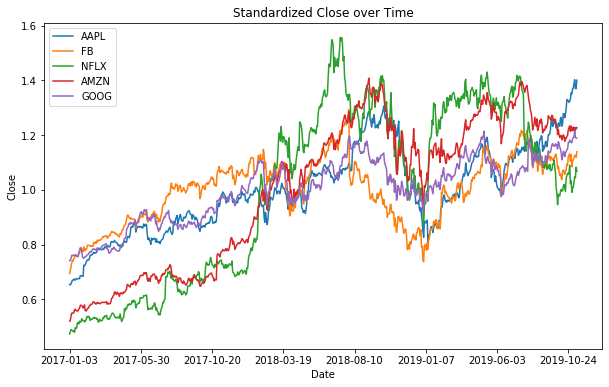

In [4]:
plot_trend(stocks, market_dfs, "Close", standardize=True)

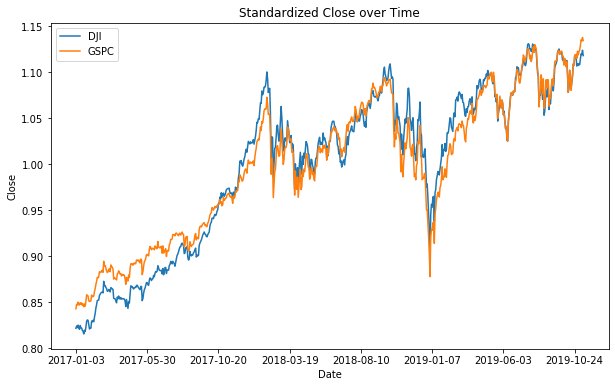

In [5]:
plot_trend(indices, market_dfs, "Close", standardize=True)

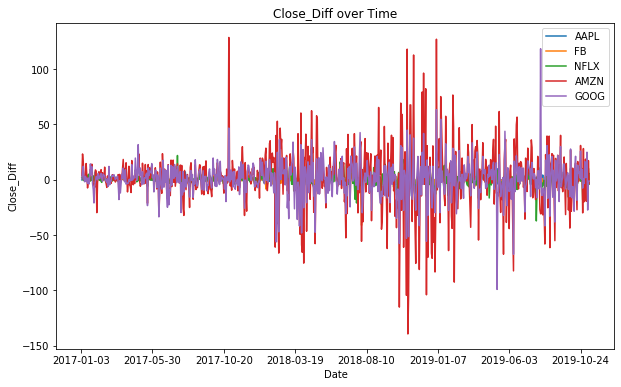

In [6]:
plot_trend(stocks, market_dfs, "Close_Diff")

# News Data

In [7]:
news_df = pd.read_csv('nytimes_2015_2019.csv')

In [8]:
news_df.head()

,web_url,snippet,lead_paragraph,abstract,print_page,source,headline,headline_kicker,headline_content_kicker,headline_print_headline,...,headline_seo,headline_sub,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,word_count
0,https://www.nytimes.com/2015/01/08/world/ameri...,"Born through a mix of frustration, satire and ...","MONTERREY, Mexico — Inside a large, open-air b...","Born through a mix of frustration, satire and ...",9.0,The New York Times,A Bus Takes a Local Route to Fighting Mexican ...,Monterrey Journal,NaN,A Bus Takes a Local Route to Fighting Mexican ...,...,NaN,NaN,"[{'name': 'persons', 'value': 'Villegas, Pauli...",2015-01-08T00:45:08+0000,article,Foreign,World,"{'original': 'By Paulina Villegas', 'person': ...",News,1030
1,https://www.nytimes.com/2015/01/11/business/mu...,So-called dark trading — when computers serve ...,"JUDGING solely by the name, stock trading in s...",So-called dark trading — when computers serve ...,29.0,The New York Times,The Rise of Trading in the Dark,Datapoints,NaN,The Rise of Trading in the Dark,...,NaN,NaN,"[{'name': 'subject', 'value': 'Stocks and Bond...",2015-01-09T21:44:42+0000,article,SundayBusiness,Business Day,"{'original': 'By Anna Bernasek', 'person': [{'...",News,366
2,https://www.nytimes.com/2015/01/11/business/fo...,"In the fixed-income market, 2014 was frustrati...",BONDS confounded conventional wisdom in 2014 w...,"In the fixed-income market, 2014 was frustrati...",16.0,The New York Times,"For Bond Investors, That Other Shoe Still Didn...",NaN,NaN,"For Bond Investors, the Other Shoe Still Didn’...",...,NaN,NaN,"[{'name': 'subject', 'value': 'Stocks and Bond...",2015-01-09T21:46:05+0000,article,NODESK,Business Day,"{'original': 'By Carla Fried', 'person': [{'fi...",News,1269
3,https://www.nytimes.com/2015/01/11/business/pe...,A Canadian investor takes a chance on a pace-s...,The typical origin story for a tech company in...,A Canadian investor takes a chance on a pace-s...,1.0,The New York Times,The Uphill Push to Save a Bike-Share Pioneer,NaN,NaN,The Uphill Push to Save a Bike-Share Pioneer,...,NaN,NaN,"[{'name': 'subject', 'value': 'Bicycles and Bi...",2015-01-09T21:03:51+0000,article,SundayBusiness,Business Day,"{'original': 'By Ian Austen', 'person': [{'fir...",News,1923
4,https://www.nytimes.com/2015/01/06/business/in...,"The euro's continued plunge, to a nine-year lo...",FRANKFURT — The value of the euro fell to its ...,"The euro's continued plunge, to a nine-year lo...",5.0,The New York Times,Falling Euro Fans Fears of a Regional Slowdown,NaN,NaN,Sliding Euro Fans Fears of a Slowdown,...,NaN,NaN,"[{'name': 'persons', 'value': 'Ewing, Jack', '...",2015-01-05T21:05:04+0000,article,Business,Business Day,"{'original': 'By Jack Ewing', 'person': [{'fir...",News,1157


In [9]:
# drop duplicates
print(len(news_df))
news_df = news_df.drop_duplicates()
print(len(news_df))

61844
45447


In [10]:
news_df.columns

Index(['web_url', 'snippet', 'lead_paragraph', 'abstract', 'print_page',
       'source', 'headline', 'headline_kicker', 'headline_content_kicker',
       'headline_print_headline', 'headline_name', 'headline_seo',
       'headline_sub', 'keywords', 'pub_date', 'document_type', 'news_desk',
       'section_name', 'byline', 'type_of_material', 'word_count'],
      dtype='object')

### Delete Columns with Missing Data

In [11]:
# percentage of each column that's missing
news_df.isna().sum() / len(news_df)

web_url                    0.000044
snippet                    0.000286
lead_paragraph             0.001276
abstract                   0.000242
print_page                 0.362180
source                     0.003477
headline                   0.000000
headline_kicker            0.823861
headline_content_kicker    1.000000
headline_print_headline    0.304597
headline_name              1.000000
headline_seo               1.000000
headline_sub               1.000000
keywords                   0.000000
pub_date                   0.000000
document_type              0.000000
news_desk                  0.039695
section_name               0.000000
byline                     0.000000
type_of_material           0.008669
word_count                 0.000000
dtype: float64

### Delete Irrelevant Columns

In [12]:
news_df = news_df.drop(['web_url', 'byline', 'headline_print_headline', 'document_type'], axis=1)

In [13]:
# these are missing more than abstract and contain similar info
news_df = news_df.drop(['snippet', 'lead_paragraph'], axis=1)

# all missing data
news_df = news_df.drop(['headline_content_kicker', 'headline_name', 'headline_seo', 'headline_sub'], axis=1)

### Transform Columns to be More Useful

In [14]:
# make headline include kicker
news_df['full_headline'] = news_df[['headline', 'headline_kicker']].apply(lambda x: x.str.cat(sep=': '), axis=1)

del news_df['headline_kicker']
del news_df['headline']

In [15]:
# create whether or not the article was in print
news_df['is_print'] = news_df['print_page'].isna()
del news_df['print_page']

### Change to One-Hot Encoding

In [16]:
# from type of material
type_dummies = pd.get_dummies(news_df['type_of_material'].fillna('Other'), prefix='Type')
news_df = pd.concat([news_df, type_dummies], axis=1, join='inner')
news_df.rename(columns={'Type_briefing': 'Type_Briefing'}, inplace=True)

del news_df['type_of_material']

In [17]:
# from source
source_dummies = pd.get_dummies(news_df['source'].fillna('Other'), prefix='Source')
news_df = pd.concat([news_df, source_dummies], axis=1, join='inner')

del news_df['source']

In [18]:
# from news desk
news_desk_dummies = pd.get_dummies(news_df['news_desk'].fillna('Other'), prefix='Desk')
news_df = pd.concat([news_df, news_desk_dummies], axis=1, join='inner')

del news_df['news_desk']

In [19]:
# from section name
section_name_dummies = pd.get_dummies(news_df['section_name'], prefix='Section')
news_df = pd.concat([news_df, section_name_dummies], axis=1, join='inner')

del news_df['section_name']

### Change Keywords to Many-Hot Encoding

In [20]:
import ast
from collections import Counter

counter = Counter()

# Get list of all keywords
def get_most_common(x):
    keywords = set()
    for word in ast.literal_eval(x):
        keywords.add(word['value'])
    counter.update(keywords)
    return keywords

news_df['keywords'] = news_df['keywords'].apply(get_most_common)

# Pick top 100
most_common = set()
for word, counts in counter.most_common(100):
    most_common.add(word)

# Get the intersection of article's keywords and top 100
def get_keywords(x):
    keywords = x.intersection(most_common)
    return '|'.join(keywords)

# Many-hot
keywords_dummies = news_df['keywords'].apply(get_keywords).str.get_dummies()
keywords_dummies.rename(columns={x: 'Keyword_' + x for x in keywords_dummies.columns}, inplace=True)
news_df = pd.concat([news_df, keywords_dummies], axis=1, join='inner')

del news_df['keywords']

### Time

In [38]:
import dateutil.parser

news_df['time'] = news_df['pub_date'].apply(dateutil.parser.parse).apply(lambda x: (x.hour * 60 + x.minute) * 60 + x.second)
x = pd.Series(news_df['time']).value_counts().sort_index()
plt.plot(x.index, x.values)

### Sentiment Analysis

In [46]:
# Adds sentiment by TextBlob (polarity and subjectivity) to a df based on its col column
def add_sentiment(df, col):
    def polarity_and_subjectivity(x):
        sentiment = TextBlob(str(x)).sentiment
        return sentiment.polarity, sentiment.subjectivity
    df['polarity'], df['subjectivity'] = zip(*df[col].map(polarity_and_subjectivity))

add_sentiment(news_df, 'abstract')

In [47]:
news_df['date'] = news_df['pub_date'].apply(lambda x: x.strip()[:10])

### Final Columns

In [48]:
news_df.columns

Index(['abstract', 'pub_date', 'word_count', 'full_headline', 'is_print',
       'Type_An Analysis', 'Type_An Appraisal', 'Type_Audio Podcast',
       'Type_Biography', 'Type_Brief',
       ...
       'Keyword_United States International Relations',
       'Keyword_United States Politics and Government',
       'Keyword_War Crimes, Genocide and Crimes Against Humanity',
       'Keyword_Women and Girls', 'Keyword_World War II (1939-45)',
       'Keyword_Xi Jinping', 'time', 'polarity', 'subjectivity', 'date'],
      dtype='object', length=183)

In [49]:
news_df.head()

,abstract,pub_date,word_count,full_headline,is_print,Type_An Analysis,Type_An Appraisal,Type_Audio Podcast,Type_Biography,Type_Brief,...,Keyword_United States International Relations,Keyword_United States Politics and Government,"Keyword_War Crimes, Genocide and Crimes Against Humanity",Keyword_Women and Girls,Keyword_World War II (1939-45),Keyword_Xi Jinping,time,polarity,subjectivity,date
0,"Born through a mix of frustration, satire and ...",2015-01-08T00:45:08+0000,1030,A Bus Takes a Local Route to Fighting Mexican ...,False,0,0,0,0,0,...,0,0,0,0,0,0,2708,0.166667,0.433333,2015-01-08
1,So-called dark trading — when computers serve ...,2015-01-09T21:44:42+0000,366,The Rise of Trading in the Dark: Datapoints,False,0,0,0,0,0,...,0,0,0,0,0,0,78282,-0.105556,0.188889,2015-01-09
2,"In the fixed-income market, 2014 was frustrati...",2015-01-09T21:46:05+0000,1269,"For Bond Investors, That Other Shoe Still Didn...",False,0,0,0,0,0,...,0,0,0,0,0,0,78365,-0.200000,0.950000,2015-01-09
3,A Canadian investor takes a chance on a pace-s...,2015-01-09T21:03:51+0000,1923,The Uphill Push to Save a Bike-Share Pioneer,False,0,0,0,0,0,...,0,0,0,0,0,0,75831,0.000000,0.000000,2015-01-09
4,"The euro's continued plunge, to a nine-year lo...",2015-01-05T21:05:04+0000,1157,Falling Euro Fans Fears of a Regional Slowdown,False,0,0,0,0,0,...,0,0,0,0,0,0,75904,0.000000,0.141667,2015-01-05


## News Sentiment by Day

In [ ]:
news_by_date = {"date": news_df.date.unique(),"subjectivity": [], "polarity": []}
for date in news_df.date.unique():
    news_by_date["subjectivity"].append(np.mean(news_df.loc[news_df['date'] == date]['subjectivity']))
    news_by_date["polarity"].append(np.mean(news_df.loc[news_df['date'] == date]['polarity']))
avg_sentiment_df = pd.DataFrame(news_by_date).sort_values(by="date")
add_day_change(avg_sentiment_df, ["subjectivity","polarity"])

In [ ]:
fig = plt.figure(figsize=(10,8))

plt.plot(list(range(len(avg_sentiment_df))), avg_sentiment_df['polarity'])
plt.plot(list(range(len(avg_sentiment_df))), avg_sentiment_df['subjectivity'])
plt.title('News Sentiment by Day')
plt.legend(['Polarity', 'Subjectivity'])

plt.show()

## Classifier

In [99]:
gspc = market_dfs['GSPC'][['Date']]
gspc['close'] = market_dfs['GSPC']['Close_Diff'] > 0

data = pd.merge(news_df.groupby('date').mean().reset_index(), gspc, how='inner', 
                left_on=['date'], right_on=['Date'])
data.dropna(subset=['close'], inplace=True)
X = data.drop(['Date', 'date', 'time', 'close'], axis=1)
Y = data['close']

/Users/Abby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

classifier = DecisionTreeClassifier()
classifier.fit(X_train, Y_train)
print(classifier.score(X_test, Y_test))

0.5034965034965035


## Regression

In [94]:
data = pd.merge(news_df.groupby('date').mean().reset_index(), market_dfs['GSPC'], how='inner', 
                left_on=['date'], right_on=['Date'])
data.dropna(subset=['Close_Diff'], inplace=True)
X = data.drop(['date', 'time', 'polarity', 'subjectivity', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 
               'Volume', 'Close_Diff', 'Volume_Diff'], axis=1)
Y = data['Close_Diff']

In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, Y_train)
print(model.score(X_test, Y_test))

-0.33496887345715143


Text(0, 0.5, 'Predictions')

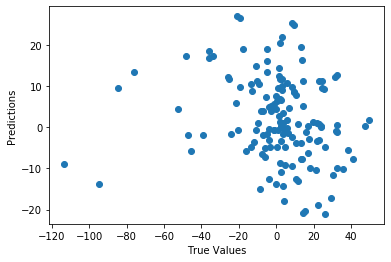

In [90]:
plt.scatter(Y_test, model.predict(X_test))
plt.xlabel('True Values')
plt.ylabel('Predictions')